# <font color="#4682B4"> BAD Day 1: Multiple hypothesis testing on Golub </font>


## 1. Loading the dataset

In [2]:
require(multtest)
data(golub)

Loading required package: multtest
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory mate

Gene expression data (3051 genes and 38 tumor mRNA samples) from the leukemia microarray study of Golub et al. (1999). Pre-processing was done as described in Dudoit et al. (2002). The R code for pre-processing is available in the file ../doc/golub.R.

In [3]:
golub.expr<-golub
row.names(golub.expr)=golub.gnames[,3]

Numeric vector indicating the tumor class, 27 acute lymphoblastic leukemia (ALL) cases (code 0) and 11 acute myeloid leukemia (AML) cases (code 1).

In [4]:
colnames(golub.expr)= golub.cl

Setting the sample sizes

In [5]:
n.ALL <- 27
n.AML <- 11
cancer.type <- c(rep("ALL", n.ALL), rep("AML", n.AML))

Adding the cancer type to the column name, for the display

In [6]:
colnames(golub.expr) <-cancer.type

## 2. t.test with a single gene

In [7]:
g <- 347

Alternatively, you can select a gene randomly

In [8]:
## g <- sample(1:nrow(golub.expr),1)
g.profile <- as.vector(as.matrix(golub.expr[g,]))

Draw a barplot wiht color-coded cancer type

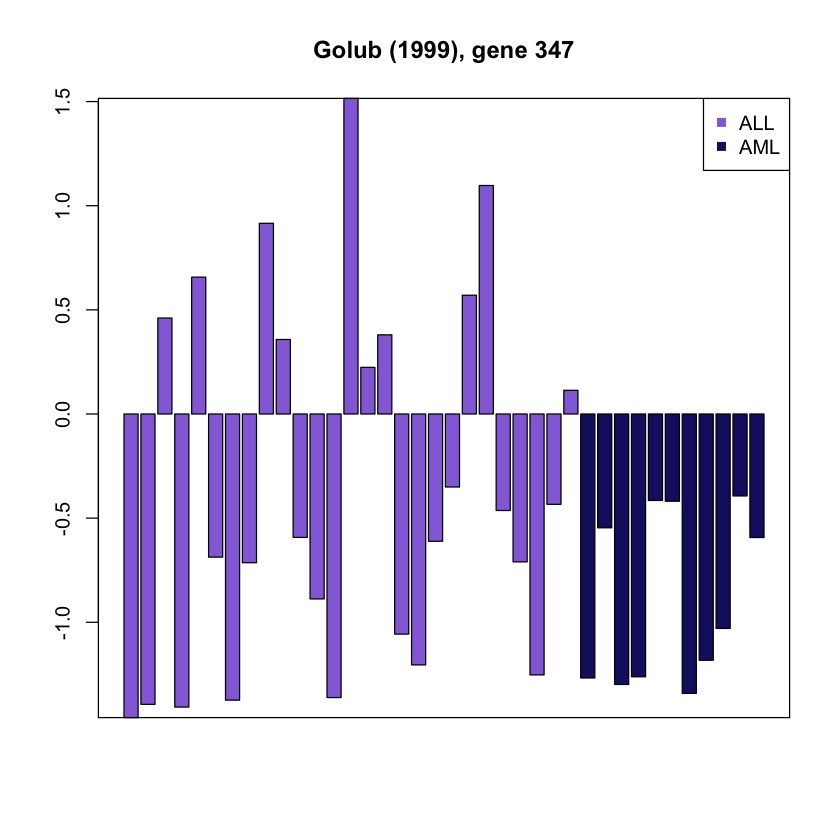

In [11]:
plot.col <- c('ALL'='mediumpurple', 'AML'='midnightblue')

barplot(g.profile, main = paste("Golub (1999), gene", g), 
        col = plot.col[cancer.type])

legend('topright', c("ALL","AML"),col = plot.col[c("ALL","AML")],
       pch = 15, bty = "o")
box()

Separate data in two vectors

In [9]:
sample.ALL <- g.profile[cancer.type=="ALL"]
sample.AML <- g.profile[cancer.type=="AML"]

Compute **manually** the t test paramenters (not necessary, just to practice!) 

Estimate the population means

In [10]:
mean.est.ALL <- mean(sample.ALL)
mean.est.AML <- mean(sample.AML)

Compute the sample sd

Remember the `sd( )` function automatically computes the estimate corrected with sqrt(n-1)

In [11]:
sample.sd.ALL <- sd(sample.ALL) * sqrt((n.ALL-1)/n.ALL)
sample.sd.AML <- sd(sample.AML) * sqrt((n.AML-1)/n.AML)

Estimate the population standard deviation

In [12]:
sd.est.ALL <- sd(sample.ALL)
sd.est.AML <- sd(sample.AML)

Estimate the standard errors on the mean

In [13]:
sd.err.est.ALL <- sd(sample.ALL) / sqrt(n.ALL)
sd.err.est.AML <- sd(sample.AML) / sqrt(n.AML)

Estimate the standard deviation of the difference between the two means according to Student's formula

In [14]:
diff.sd.est <- sqrt((n.ALL*sample.sd.ALL^2 + n.AML*sample.sd.AML^2) * (1/n.ALL + 1/n.AML) /(n.ALL+n.AML-2))

Compute `t.obs`

In [15]:
d <- abs(mean.est.ALL - mean.est.AML)
t.obs.Student <- d/diff.sd.est

Compute the P- vale.
Since we are performing the two-tail test, the single-tail probability has to be multiplied by 3 in order to obtai the alpha risk

In [16]:
P.val.Student <- 2 * pt(q = t.obs.Student, df = n.ALL + n.AML-2, lower.tail = F)

### This is what you should be doing... FAST! 

## 3. Apply the Student-Fischer t-test (this assumes that the two populations have equal variance).


In [17]:
t.student <- t.test(sample.ALL,sample.AML, var.equal=TRUE)
print(t.student)


	Two Sample t-test

data:  sample.ALL and sample.AML
t = 1.9201, df = 36, p-value = 0.0628
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02970999  1.08601464
sample estimates:
 mean of x  mean of y 
-0.3580622 -0.8862145 



## 4. Apply the Welch t-test (this does not assume that the two populations have equal variance)

In [18]:
t.welch <- t.test(sample.ALL,sample.AML, var.equal=FALSE)
print(t.welch) 


	Welch Two Sample t-test

data:  sample.ALL and sample.AML
t = 2.5462, df = 35.088, p-value = 0.01543
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1070944 0.9492103
sample estimates:
 mean of x  mean of y 
-0.3580622 -0.8862145 



**We want to test all the genes, so we could just loop over what was written before ... (note it can take some time)**


In [19]:
t.statistics <- vector()
P.values <- vector()
for (g in 1:nrow(golub.expr)) {
  #  print(paste("Testing gene", g))
  g.profile <- as.vector(golub.expr[g,])
  sample.ALL <- g.profile[cancer.type=="ALL"]
  sample.AML <- g.profile[cancer.type=="AML"]
  t <- t.test(sample.ALL,sample.AML)
  t.statistics <- append(t.statistics, t$statistic)
  P.values <- append(P.values, t$p.value)
}

In [20]:
 print(P.values)

   [1] 1.061689e-01 3.800914e-01 9.232111e-01 7.369011e-01 1.822725e-01
   [6] 2.169132e-01 4.751290e-01 5.970911e-01 9.867712e-01 8.935067e-01
  [11] 7.982573e-04 1.657514e-02 1.815017e-03 6.615150e-01 8.501594e-01
  [16] 7.317288e-01 7.216203e-02 1.549732e-02 6.901910e-01 3.455687e-02
  [21] 1.595469e-01 6.575488e-01 8.740984e-05 4.980659e-01 3.995630e-02
  [26] 1.837360e-01 7.055612e-01 9.597674e-01 2.159967e-01 6.663145e-01
  [31] 8.974813e-01 9.330530e-04 7.868697e-01 2.677269e-01 1.163196e-02
  [36] 2.437662e-02 2.977154e-01 7.006016e-01 3.063250e-03 1.223571e-01
  [41] 1.140443e-01 2.705021e-01 1.288982e-02 3.401258e-01 3.765952e-01
  [46] 3.100744e-01 1.634335e-01 1.008457e-01 2.663350e-01 3.321313e-03
  [51] 1.091638e-02 5.592840e-01 1.491508e-01 4.256086e-01 2.476992e-04
  [56] 4.847619e-04 5.301152e-01 9.811613e-01 8.047112e-02 2.215574e-02
  [61] 1.086356e-01 5.198655e-03 7.965254e-02 2.755128e-01 3.877009e-01
  [66] 1.121869e-04 8.820677e-02 8.563486e-05 3.538697e-01 5.549

#### For a more efficient way, you can use apply

In [21]:
Data=cbind(golub.expr,P.values)
colnames(Data)[39]='Raw.p'

Order data by pvalue

In [22]:
Data = Data[order(Data[,'Raw.p']),]

Perform p-value adjustments and add to the data frame

In [23]:
Datadf <- as.data.frame(Data)

In [24]:
Datadf$Bonferroni = 
  p.adjust(Datadf$Raw.p, 
           method = "bonferroni")

Datadf$BH = 
  p.adjust(Datadf$Raw.p, 
           method = "BH")

Datadf$Holm = 
  p.adjust(Datadf$ Raw.p, 
           method = "holm")

Datadf$Hochberg = 
  p.adjust(Datadf$ Raw.p, 
           method = "hochberg")

Datadf$Hommel = 
  p.adjust(Datadf$ Raw.p, 
           method = "hommel")

Datadf$BY = 
  p.adjust(Datadf$ Raw.p, 
           method = "BY")

## 5. Plotting the obtained data

In [25]:
X = Datadf$Raw.p
Y = cbind(Datadf$Bonferroni,
          Datadf$BH,
          Datadf$Holm,
          Datadf$Hochberg,
          Datadf$Hommel,
          Datadf$BY)

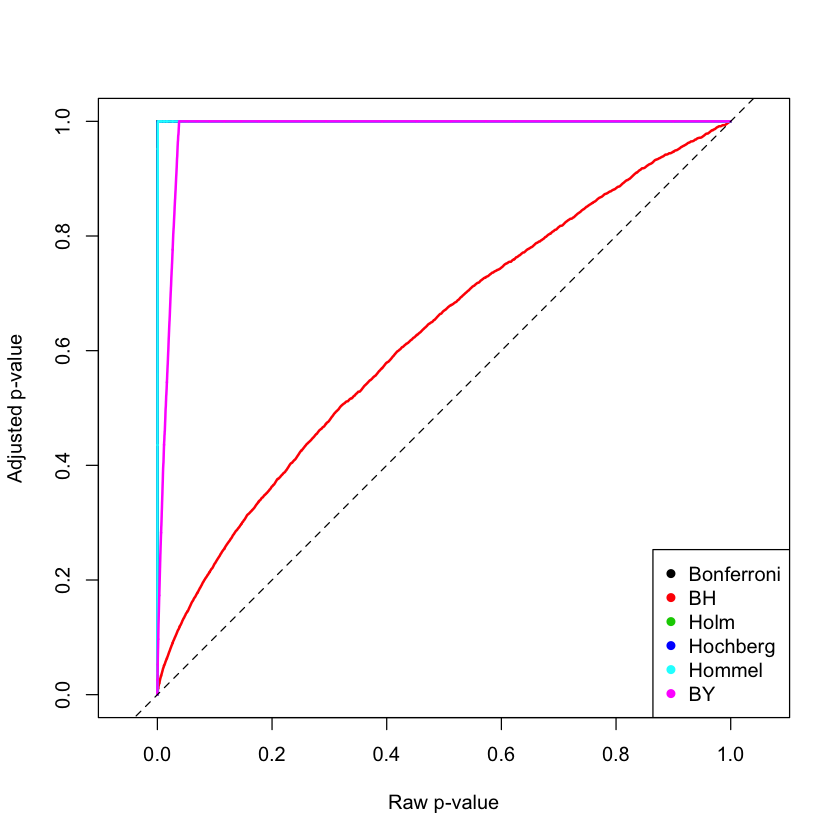

In [26]:
matplot(X, Y,
        xlab="Raw p-value",
        ylab="Adjusted p-value",
        type="l",
        asp=1,
        col=1:6,
        lty=1,
        lwd=2)

legend('bottomright', 
       legend = c("Bonferroni", "BH", "Holm", "Hochberg", "Hommel", "BY"), 
       col = 1:6, 
       cex = 1,    
       pch = 16)

abline(0, 1,
       col=1,
       lty=2,
       lwd=1)

